In [1]:
# import importlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from matplotlib.image import imread


%matplotlib inline

import cmocean
from glob import glob
import os

from datetime import timedelta, datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import gridspec


import pop_tools

#import oae_smyle
import util
from scipy.spatial import ConvexHull, Delaunay
import random
import importlib
import gsw

In [2]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

# Fig. 5
Decomposition of gas exchange timescale

In [4]:
all_curves_global = xr.open_dataset('./data/curves_Eta_fracExcessALKsurf.nc', decode_times=False)
all_curves_global_tau_FG_CO2 = xr.open_dataset('./data/curves_tau_decomposition_noTau.nc', decode_times=False)

poly_ind = [0, 126, 142, 129]
season = [0,1,2,3]

def no_nans(array):
    return array[~np.isnan(array)]

# extract all tau files for Atlantic
tau_curves = []
for p in poly_ind:
    l_tau = []
    for s in season:
        res = all_curves_global_tau_FG_CO2.isel(region=1, polygon=p, season=s)
        
        res['tau_gas_approxi_weight_1'] = res.mld_weight_1 * res.dDICdCO2_approxi_weight_1 / res.piston_weight_1/86400 
        res = res.compute()
        
        # Add effective mld using the dilution curves, and effective tau using effective mld
        res['mld_effective'] = 1000 / all_curves_global.isel(region=1, polygon=p, season=s).frac_ALK_excess_surf  # top layer is 10,00 cm
        res = res.compute()
        
        res['tau_gas_approxi_weight_1_effectiveMLD'] = res.mld_effective * res.dDICdCO2_approxi_weight_1 / res.piston_weight_1/86400
        res = res.compute()
        
        res['tau_gas_approxi_weight_1'].attrs['units']='days'
        res['mld_effective'].attrs['units']='cm'
        res['tau_gas_approxi_weight_1_effectiveMLD'].attrs['units']='days'

        l_tau.append(res)
    tau_curves.append(l_tau)

CPU times: user 465 ms, sys: 26 ms, total: 491 ms
Wall time: 567 ms


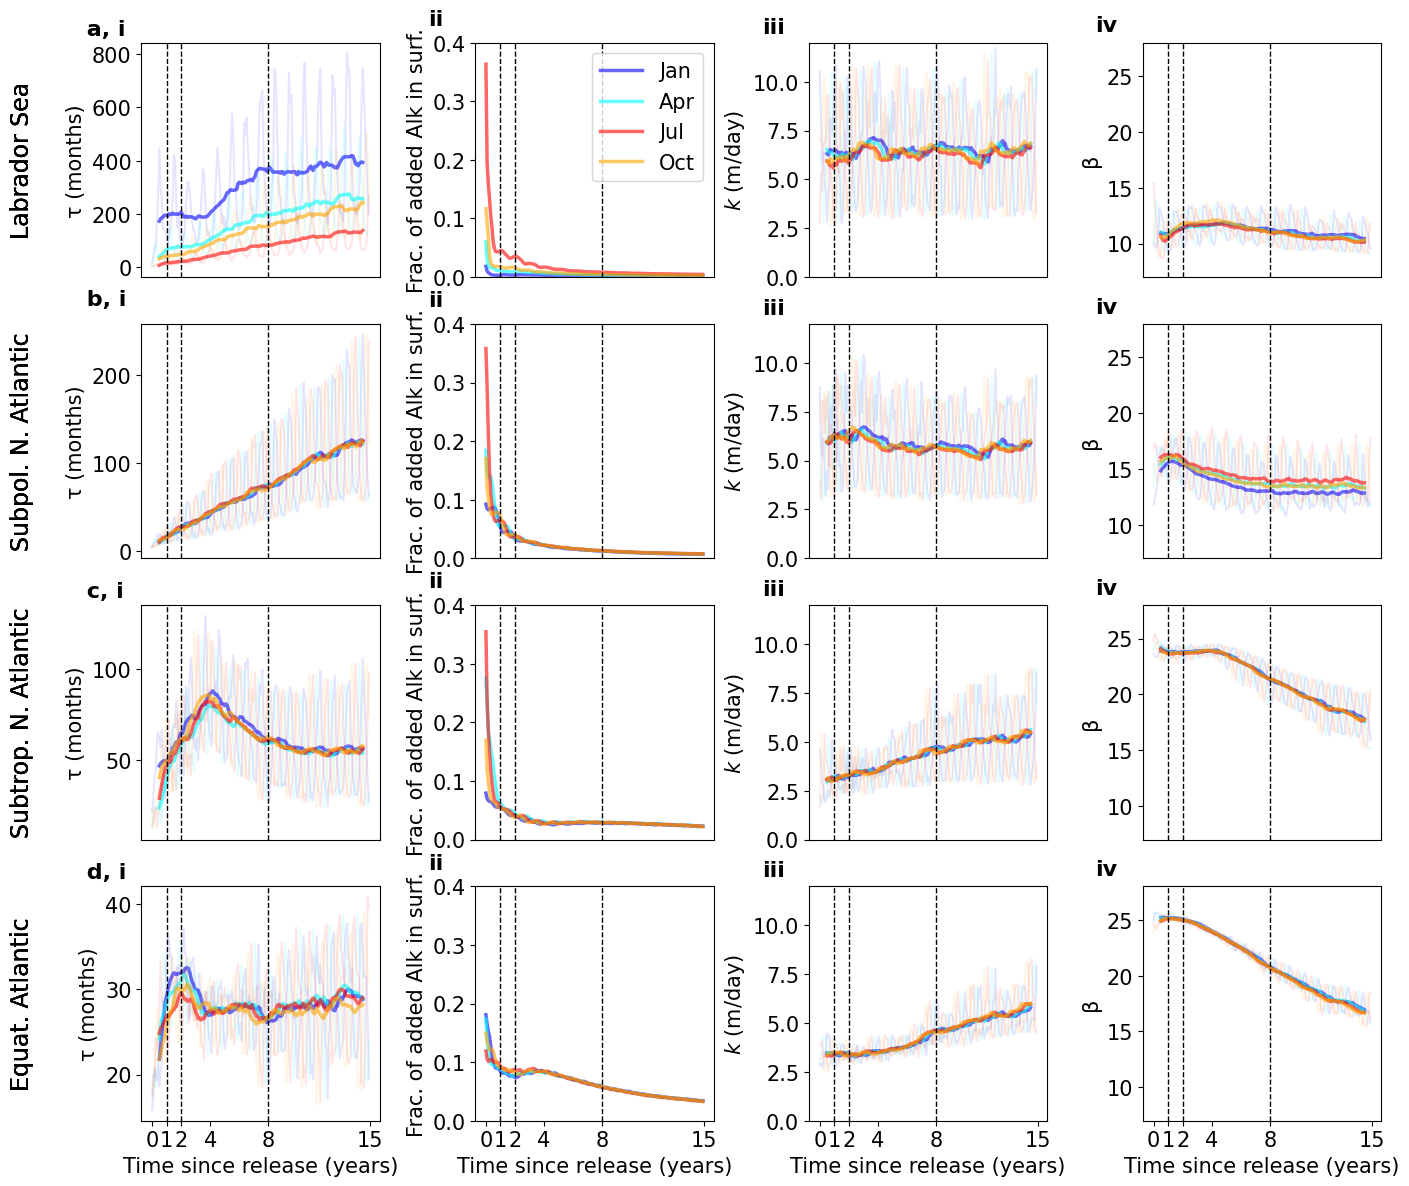

In [5]:
%%time
plt.rcParams.update({'font.size': 15})

nrow = 4
ncol = 4

fig = plt.figure(figsize=(16,14))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1])

colors = ['blue', 'cyan', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -80, -80]
lon_maxs = [25, 25, 30, 30]
lat_mins = [0, 0, 0, -40]
lat_maxs = [80, 80, 80, 40]
central_longitudes = [0, 0, 0, 0]

reg = ['Atlantic', 'Atlantic', 'Atlantic', 'Atlantic']
polys = [0, 126, 142, 129]


#text_position = [750,95,125,39.5]
text_position = [870,280,140,43]
text_position_1 = [870,110,140,43]
ll = ['a', 'b', 'c', 'd']
region_names = ['Labrador Sea', 'Subpol. N. Atlantic', 'Subtrop. N. Atlantic', 'Equat. Atlantic']

for i in range(nrow): # polygon
    
    surf_dil = all_curves_global.sel(region=reg[i], polygon=polys[i])  # surface dilution curves for a polygon, with 4 seasons
    tau_comp = tau_curves[i] # this polygon 4 season
    #tau_comp = all_curves_global_tau_FG_CO2.sel(region=reg[i], polygon=polys[i]) # tau gax componets for a region
    
    for j in range(ncol): # season

        ################ tau_gas_effective_MLD
        if j == 0:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-5, text_position[i], f' {ll[i]}, i', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp[k].tau_gas_approxi_weight_1_effectiveMLD.values/30), linewidth=1.5, color=colors[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp[k].tau_gas_approxi_weight_1_effectiveMLD.values)
                ax.plot(tarray, tau_comp[k].tau_gas_approxi_weight_1_effectiveMLD.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan]/30, linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                #ax.set_ylim(7, 26)
                ax.set_ylabel('τ (months)')
                ax.text(-0.5, 0.5, f'{region_names[i]}', ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=17)  
                #ax.text(-8, text_position[i]/3, f'{region_names[i]}', rotation=90)
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
        
        ################ surf_dil
        elif j == 1:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 0.43, 'ii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(surf_dil.isel(season=k).frac_ALK_excess_surf.values), linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)
                ax.set_ylim(0, 0.4)
                ax.set_ylabel('Frac. of added Alk in surf.')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])
            if i == 0:
                ax.legend(loc='upper right')

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )


        ################ piston velocity
        elif j == 2:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 12.5, 'iii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp[k].piston_weight_1.values/100*86400), linewidth=1.5, color=colors[k], label=labels[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp[k].piston_weight_1.values)
                ax.plot(tarray, tau_comp[k].piston_weight_1.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan]/100*86400, linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                ax.set_ylim(0, 12)
                ax.set_ylabel('$k$ (m/day)')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
        ################ dDIC_dCO2
        elif j == 3:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 29, 'iv', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp[k].dDICdCO2_approxi_weight_1.values), linewidth=1.5, color=colors[k], label=labels[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp[k].dDICdCO2_approxi_weight_1.values)
                ax.plot(tarray, tau_comp[k].dDICdCO2_approxi_weight_1.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan], linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                ax.set_ylim(7, 28)
                ax.set_ylabel('β')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# plt.savefig('./figures/Figure_5.png', dpi=400, bbox_inches='tight')
# plt.savefig('./figures/Figure_5.pdf', bbox_inches='tight')

# Fig. 2

Read data

In [6]:
all_curves_global = xr.open_dataset('./data/curves_Eta_fracExcessALKsurf.nc', decode_times=False)
all_curves_global_tau_FG_CO2 = xr.open_dataset('./data/curves_tau_decomposition_noTau.nc', decode_times=False)

In [7]:
# surface pCO2 deficit at year 2 for January releases
ds = xr.open_dataset('./data/plumes_data/pCO2_SURF_excess_0_Atlantic.nc')
ds_142 = xr.open_dataset('./data/plumes_data/pCO2_SURF_excess_142_Atlantic.nc')
ds_129 = xr.open_dataset('./data/plumes_data/pCO2_SURF_excess_129_Atlantic.nc')
ds_126 = xr.open_dataset('./data/plumes_data/pCO2_SURF_excess_126_Atlantic.nc')

# vertical distribution of fraction of excess ALK
frac_alk_invertical = xr.open_dataset('./data/plumes_data/frac_alk_invertical_0_jan_Atlantic.nc')
frac_alk_invertical_apr = xr.open_dataset('./data/plumes_data/frac_alk_invertical_0_apr_Atlantic.nc')
frac_alk_invertical_jul = xr.open_dataset('./data/plumes_data/frac_alk_invertical_0_jul_Atlantic.nc')
frac_alk_invertical_oct = xr.open_dataset('./data/plumes_data/frac_alk_invertical_0_oct_Atlantic.nc')

frac_alk_invertical_142 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_142_jan_Atlantic.nc')
frac_alk_invertical_apr_142 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_142_apr_Atlantic.nc')
frac_alk_invertical_jul_142 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_142_jul_Atlantic.nc')
frac_alk_invertical_oct_142 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_142_oct_Atlantic.nc')

frac_alk_invertical_129 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_129_jan_Atlantic.nc')
frac_alk_invertical_apr_129 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_129_apr_Atlantic.nc')
frac_alk_invertical_jul_129 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_129_jul_Atlantic.nc')
frac_alk_invertical_oct_129 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_129_oct_Atlantic.nc')

frac_alk_invertical_126 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_126_jan_Atlantic.nc')
frac_alk_invertical_apr_126 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_126_apr_Atlantic.nc')
frac_alk_invertical_jul_126 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_126_jul_Atlantic.nc')
frac_alk_invertical_oct_126 = xr.open_dataset('./data/plumes_data/frac_alk_invertical_126_oct_Atlantic.nc')

#### put together
dss = [ds, ds_126, ds_142, ds_129]

fra_alks = [ [frac_alk_invertical, frac_alk_invertical_apr, frac_alk_invertical_jul, frac_alk_invertical_oct],\
[frac_alk_invertical_126, frac_alk_invertical_apr_126, frac_alk_invertical_jul_126, frac_alk_invertical_oct_126],\
[frac_alk_invertical_142, frac_alk_invertical_apr_142, frac_alk_invertical_jul_142, frac_alk_invertical_oct_142],\
[frac_alk_invertical_129, frac_alk_invertical_apr_129, frac_alk_invertical_jul_129, frac_alk_invertical_oct_129] ]

# OAE efficiency curves for only atlantic
poly_ind = [0, 126, 142, 129]
season = [0,1,2,3]

oae_effs = []
for p in poly_ind:
    l = []
    for s in season:
        l.append(all_curves_global.isel(region=1, polygon=p, season=s))
    oae_effs.append(l)

In [10]:
def plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, ii):
    # a list of colors
    # colorsss = list(mcolors.TABLEAU_COLORS.values())
    # ind_color = np.arange(len(colorsss)) # 0- 9

    vertices = np.array(final_polygon_vertices_atlantic[ii])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[iii] for iii in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[ii] == 1)
    ax.scatter(tlong[index], tlat[index], c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[ii, 0]-2, cluster_centers_atlantic[ii, 1]-1,str(ii), fontsize=9, color='k', transform=ccrs.PlateCarree())

# atlantic polygon masks
final_polygon_mask_atlantic = np.load('./data/polygon_data/Atlantic_final_polygon_mask.npy')
final_polygon_vertices_atlantic = np.load('./data/polygon_data/Atlantic_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_atlantic = np.load('./data/polygon_data/Atlantic_final_cluster_centers.npy', allow_pickle=True)

# Adding mixed layer depth weighted by modulus FG_CO2_excess
## for only atlantic
poly_ind = [0, 126, 142, 129]
season = [0,1,2,3]

eff_mld = np.zeros((4, 4, 3))  # number of polygons, number of season, number of years

for i in range(4): # polygon
    for j in range(4): # season
        eff_mld[i,j,0] = no_nans(all_curves_global_tau_FG_CO2.isel(region=1, polygon=poly_ind[i], season=j).mld_weight_1.values)[12*1]/100 
        eff_mld[i,j,1] = no_nans(all_curves_global_tau_FG_CO2.isel(region=1, polygon=poly_ind[i], season=j).mld_weight_1.values)[12*2]/100
        eff_mld[i,j,2] = no_nans(all_curves_global_tau_FG_CO2.isel(region=1, polygon=poly_ind[i], season=j).mld_weight_1.values)[12*8]/100

In [11]:
print(eff_mld)

[[[128.9043727   96.55247834 217.54975337]
  [ 62.06159412  70.47887471 120.82978566]
  [ 12.01554877  14.65921186  15.29126874]
  [ 43.49949426  42.49384065  55.11549891]]

 [[121.29728316 207.53963527 165.01712944]
  [ 75.56342617  57.26477038  87.6136324 ]
  [ 16.79596111  19.29666668  20.5615026 ]
  [ 74.04967893  57.40145763  45.39114194]]

 [[ 73.023433    61.11046224 102.10914901]
  [ 33.18881966  26.8730618   38.66525288]
  [ 18.67291148  26.8273255   22.22077452]
  [ 33.40023321  31.59464288  35.90654088]]

 [[ 30.44549012  40.48154803  82.86614151]
  [ 32.98308495  35.11885074  38.29945314]
  [ 49.31177132  43.83980888  55.71905091]
  [ 41.37499661  31.46776266  38.23346142]]]


/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


CPU times: user 591 ms, sys: 17.3 ms, total: 609 ms
Wall time: 996 ms


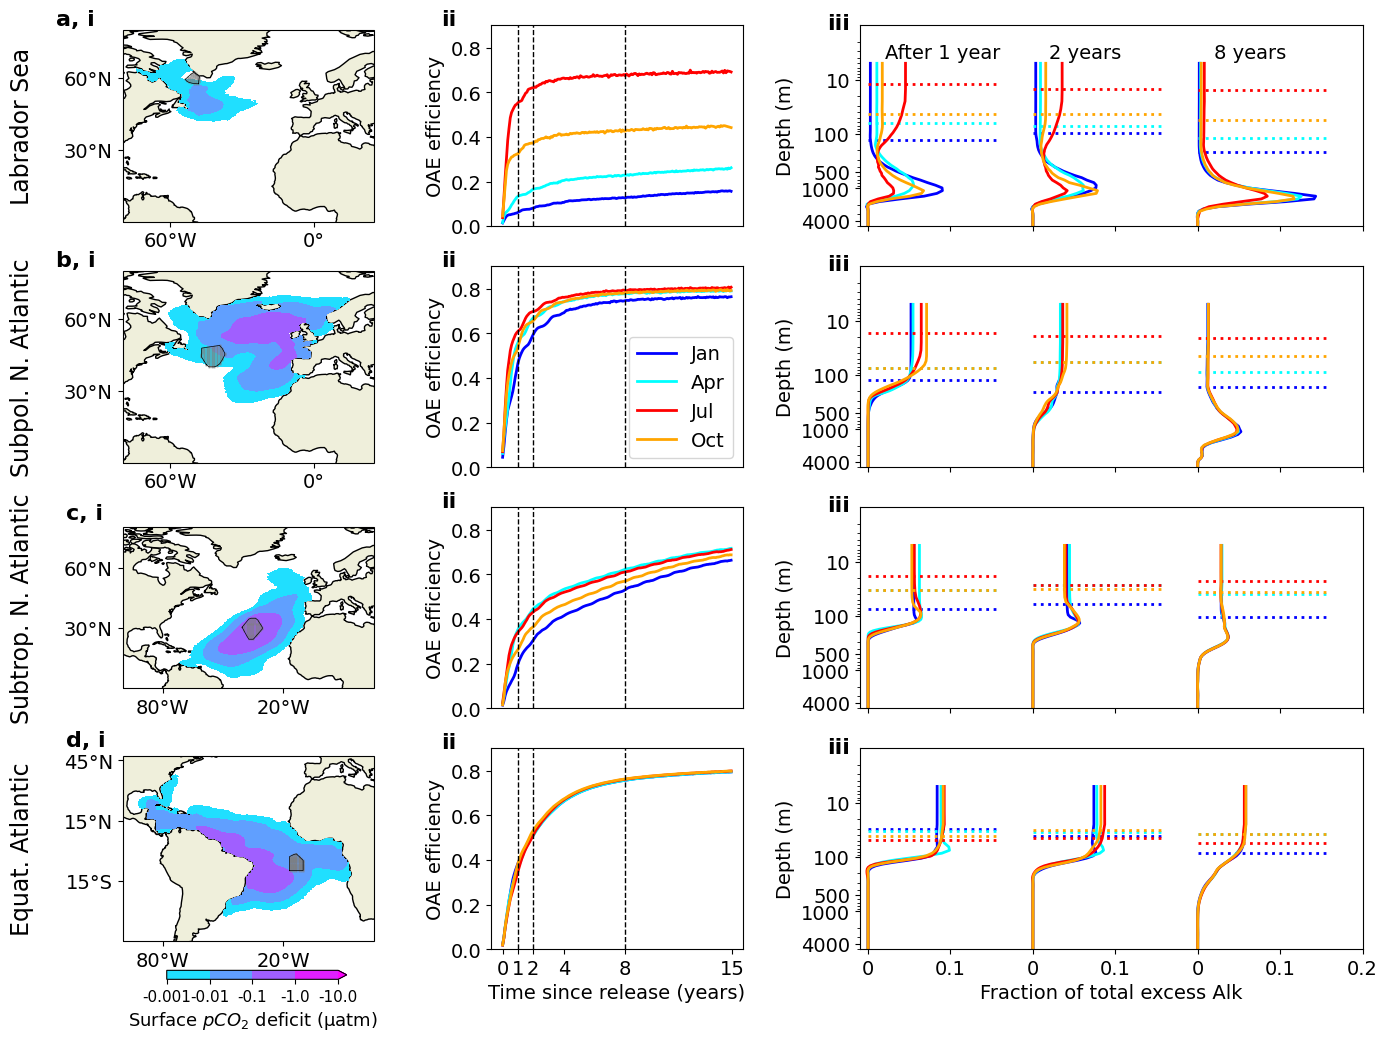

In [12]:
%%time
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4, 3, width_ratios=[1, 1, 2])

colors = ['blue', 'cyan', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -100, -100]
lon_maxs = [25, 25, 25, 25]
lat_mins = [0, 0, 0, -45]
lat_maxs = [80, 80, 80, 47]
central_longitudes = [0, 0, 0, 0]
region_names  = ['Labrador Sea','Subpol. N. Atlantic','Subtrop. N. Atlantic','Equat. Atlantic']

def modify_ax_alk(ax):
    ax.set_ylim(5000, 1)
    ax.set_yscale('log')
    
    custom_y_ticks = [10, 100, 500, 1000, 4000]
    custom_y_labels  = [str(num) for num in custom_y_ticks]
    ax.set_yticks(custom_y_ticks)
    ax.set_yticklabels(custom_y_labels);
    
    ax.set_xlim(-0.01, 0.6)
    custom_x_ticks = np.arange(0, 0.7, 0.1)
    custom_x_labels  = [0, 0.1, 0, 0.1, 0, 0.1, 0.2]
    custom_x_labels = [str(num) for num in custom_x_labels]
    ax.set_xticks(custom_x_ticks)
    ax.set_xticklabels(custom_x_labels);


for i in range(4): # polygon
    oae_ = oae_effs[i] # OAE_result for a polygon
    frac_alk_ = fra_alks[i] # frac_alk for a polygon
    
    for j in range(3):
        if j == 0:
            #ax = fig.add_subplot(4, 3, i*3+j+1, projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            ax = plt.subplot(gs[i, j], projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            ax.text(-0.4, 0.5, f'{region_names[i]}', ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=17)  

            ### add map
            ds_ = util.pop_add_cyclic(dss[i])

            lon_min = lon_mins[i]
            lon_max = lon_maxs[i]
            lat_min = lat_mins[i]
            lat_max = lat_maxs[i]

            custom_colorbar_ticks = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
            negated_numbers = [-num for num in custom_colorbar_ticks]
            custom_colorbar_labels  = [str(num) for num in negated_numbers]

            sca = ax.contourf(ds_.TLONG, ds_.TLAT, -ds_.pCO2_SURF_excess,
                              transform=ccrs.PlateCarree(),
                              cmap=plt.cm.cool,

                              levels = custom_colorbar_ticks,
                              # #levels=[-1e1, -1e0, -1e-1, -1e-2, -1e-3, -1e-4],
                              extend='max',
                              norm=LogNorm(),              
                             );
            def modify(ax):
                ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
                ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
                lon_formatter = LongitudeFormatter(zero_direction_label=False)
                lat_formatter = LatitudeFormatter()
                ax.xaxis.set_major_formatter(lon_formatter)
                ax.yaxis.set_major_formatter(lat_formatter) 

                ax.add_feature(cfeature.LAND, edgecolor='black')
###### colorbar
                if i == 0:
                    cax = fig.add_axes([-0.27, 0.085, 1, 0.05])  # left, bottom, width, height
                    cb = fig.colorbar(sca, ax=cax, shrink=1, orientation='horizontal')
                    cb.ax.set_title('Surface $pCO_2$ deficit (µatm)', y=-6, fontsize=13)
                    cb.set_ticks(custom_colorbar_ticks)
                    cb.set_ticklabels(custom_colorbar_labels)
                    cb.ax.tick_params(axis='x', labelsize=11)
                
            modify(ax)
            
            ## add polygons
            if i == 0:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 0)
                ax.text(-108, 82, 'a, i', fontsize=16, fontweight='bold')
            elif i == 1:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 126)
                ax.text(-108, 82, 'b, i', fontsize=16, fontweight='bold')
            elif i == 2:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 142)
                ax.text(-128, 84, 'c, i', fontsize=16, fontweight='bold')
            elif i == 3:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 129)
                ax.text(-128, 52, 'd, i', fontsize=16, fontweight='bold')
        
        ################ oae eff
        elif j == 1:
            #ax = fig.add_subplot(4, 3, i*3+j+1)
            ax = plt.subplot(gs[i, j])
            ax.text(-4, 0.9, 'ii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(oae_[k].OAE_efficiency.values), linewidth=2, color=colors[k], label=labels[k])
                ax.set_ylim(0, 0.9)
                ax.set_ylabel('OAE efficiency')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
            if i == 1:
                ax.legend(loc='lower right')

        ################ vertical profiles of excess alk
        elif j == 2:
            #ax = fig.add_subplot(4, 3, i*3+j+1)
            ax = plt.subplot(gs[i, j])
            ax.text(-0.05, 1.2, 'iii', fontsize=16, fontweight='bold')
            depth_array = frac_alk_invertical.z_t.values/100  # m
            
            mld_ = eff_mld[i] # mld for this polygon
            for k in range(4): # for a season
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*1), depth_array, linewidth=2, color=colors[k], label=labels[k], linestyle='-')
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*2) + 0.2, depth_array, linewidth=2, color=colors[k], linestyle='-')
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*8) + 0.4, depth_array, linewidth=2, color=colors[k], linestyle='-')
                
                # add mld for year 1, 2, 8
                ax.plot([0, 0.2-0.04], [mld_[k,0], mld_[k,0]], color=colors[k], linestyle=':', linewidth=2)
                ax.plot([0.2, 0.4-0.04], [mld_[k,1], mld_[k,1]], color=colors[k], linestyle=':', linewidth=2)
                ax.plot([0.4, 0.6-0.04], [mld_[k,2], mld_[k,2]], color=colors[k], linestyle=':', linewidth=2)
                
                
            modify_ax_alk(ax)
            ax.set_ylabel('Depth (m)')
            if i == 3:
                ax.set_xlabel('Fraction of total excess Alk')
            else:
                ax.set_xticklabels([]);
            if i == 0:
                #ax.legend(loc='upper right')
                ax.text(0.02, 4, f'After 1 year')
                ax.text(0.22, 4, f'2 years')
                ax.text(0.42, 4, f'8 years')
                
                
                
plt.subplots_adjust(wspace=0.35, hspace=0.2)

# plt.savefig('./figures/Figure_2.png', dpi=400, bbox_inches='tight')
# plt.savefig('./figures/Figure_2.pdf', bbox_inches='tight')

## Numbers in paper

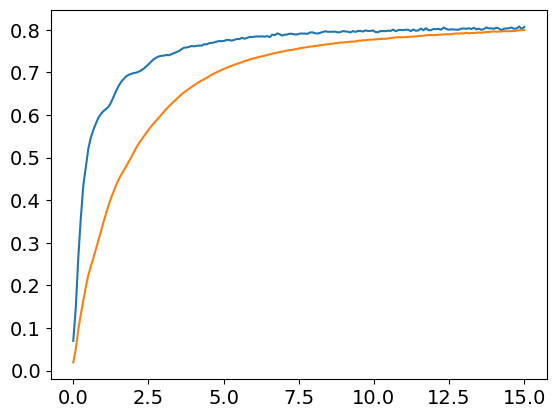

In [14]:
plt.plot(np.linspace(0,15,180), no_nans(oae_effs[1][2].OAE_efficiency.values))
plt.plot(np.linspace(0,15,180), no_nans(oae_effs[3][2].OAE_efficiency.values))

In [15]:
# polygon 126
arr = no_nans(oae_effs[1][2].OAE_efficiency.values)

# Keeping only two decimals
arr_rounded = np.round(arr, decimals=2)

# Finding the index of the maximum element
max_index = np.argmax(arr_rounded)
index = np.argmax(arr_rounded >= 0.8)


max_index/12, index/12

(12.25, 8.333333333333334)

In [16]:
arr_rounded

array([0.07, 0.15, 0.27, 0.36, 0.44, 0.48, 0.52, 0.55, 0.57, 0.58, 0.59,
       0.6 , 0.61, 0.61, 0.62, 0.63, 0.64, 0.66, 0.67, 0.68, 0.68, 0.69,
       0.69, 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.71, 0.71, 0.72, 0.73, 0.73,
       0.73, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75,
       0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.77, 0.77, 0.77,
       0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.78, 0.78, 0.77, 0.78, 0.78,
       0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78,
       0.78, 0.78, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79,
       0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79,
       0.79, 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.79, 0.79, 0.8 , 0.8 , 0.8 ,
       0.79, 0.8 , 0.79, 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.79,
       0.79, 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 ,
       0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 ,
       0.8 , 0.8 , 0.8 , 0.8 , 0.81, 0.8 , 0.8 , 0.

In [128]:
# polygon equator
arr = no_nans(oae_effs[3][2].OAE_efficiency.values)

# Keeping only two decimals
arr_rounded = np.round(arr, decimals=2)

# Finding the index of the maximum element
max_index = np.argmax(arr_rounded)

max_index/12

13.833333333333334

# Adding histograms of CO2 uptake

In [13]:
all_poly = xr.open_dataset('./data/curves_CO2spread.nc')
ds_4poly = all_poly.sel(region='North_Atlantic_basin', polygon=[0,126,142,129])

In [14]:
ds_4poly

<xarray.Dataset>
Dimensions:         (polygon: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 126 142 129
    region          <U20 'North_Atlantic_basin'
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (polygon, season, time, dist2center) float64 ...

## Map view of cumulative CO2 uptake

In [16]:
def get_cumul_CO2uptake_map(polygon, reg='North_Atlantic_basin'):
    
    fpath = './data/FG_CO2_excess/'

    ind = polygon*4
    FG_CO2_excess = xr.open_dataset(fpath + f'{reg}-{ind:04d}.nc')
    
    FG_CO2_excess_area_time = (FG_CO2_excess.FG_CO2_excess * FG_CO2_excess.TAREA * FG_CO2_excess.time_delta) / 1e6 * 86400 # mmol
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['time', 'nlat', 'nlon']).values # total CO2 uptake in 15 years, mmol

    frac_FG_CO2 = FG_CO2_excess_area_time / total_FG_CO2*100
    frac_FG_CO2_cumul = frac_FG_CO2.sum(['time'])
    
    frac_FG_CO2_cumul = frac_FG_CO2_cumul.to_dataset(name='frac_FG_CO2_cumul')
    
    return frac_FG_CO2_cumul

In [17]:
%%time
frac_FG_CO2_map_0 = get_cumul_CO2uptake_map(0)
frac_FG_CO2_map_142 = get_cumul_CO2uptake_map(142)
frac_FG_CO2_map_129 = get_cumul_CO2uptake_map(129)
frac_FG_CO2_map_126 = get_cumul_CO2uptake_map(126)

ds_frac_FG_CO2_map = [frac_FG_CO2_map_0, frac_FG_CO2_map_126, frac_FG_CO2_map_142, frac_FG_CO2_map_129]

CPU times: user 1.12 s, sys: 1.16 s, total: 2.28 s
Wall time: 2.87 s


Given ranges, calculate sums inside

In [18]:
def get_sum_inside(frac_FG_CO2_map_63, ranges):
    '''
    Given a list of max_values, return the sums inside
    '''
    data_array = frac_FG_CO2_map_63.frac_FG_CO2_cumul

    l_sum_inside = []
    for max_value in ranges:
        selected_data = data_array.where( (data_array >= max_value), drop=True)
        sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values.item()
        l_sum_inside.append(sum_inside)
    return np.array(l_sum_inside)

In [19]:
ranges = [1e-3, 0.008, 0.02, 0.1]
print(get_sum_inside(frac_FG_CO2_map_0, ranges))
print(get_sum_inside(frac_FG_CO2_map_126, ranges))
print(get_sum_inside(frac_FG_CO2_map_142, ranges))
print(get_sum_inside(frac_FG_CO2_map_129, ranges))

[98.73780535 93.87056458 86.51149795 51.47351978]
[98.92528702 88.0077969  72.92412699 31.99402001]
[97.26243717 78.10906005 60.40436093 36.32714977]
[96.42871289 73.92344397 58.66827128 24.85023715]


In [20]:
arr = get_sum_inside(frac_FG_CO2_map_0, ranges)
int_array = list(map(int, arr))

In [25]:
int_array

[98, 93, 86, 51]

Given the sums, what should be the ranges

In [21]:
def get_max_values(frac_FG_CO2_map_63, target_sums, thresholds):
    '''
    Given an array of target_sum, return the max values that will sum to the targets.
    '''

    l_max_value = []

    data_array = frac_FG_CO2_map_63.frac_FG_CO2_cumul
    
    for target, thres in zip(target_sums, thresholds):

        max_value = np.round(data_array.max().item(), 2) # start value
        
        #print("Target:", target)
        
        # Iterate to find the largest max_value that makes the sum equal to the target value
        while True:
            
            selected_data = data_array.where(data_array >= max_value, drop=True)
            sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values
            
            #print(max_value, sum_inside,target, np.abs(sum_inside - target))

            if sum_inside - target >= thres:
                break

            else:
                # Decrease max_value for the next iteration
                max_value -= 0.005
        
        l_max_value.append(max_value)
        #print("Largest max_values:", l_max_value)
    #l_max_value.append(0.001)
        
    return l_max_value

Figure out the labels and ranges one by one

In [22]:
def get_sum(frac_FG_CO2_map_0, the_num):
    
    data_array = frac_FG_CO2_map_0.frac_FG_CO2_cumul
    selected_data = data_array.where( (data_array >= the_num), drop=True)
    sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values.item()
    return sum_inside

In [23]:
L_max_value = []
L_target_sums = []

Polygon 0

In [24]:
target_sums = [30, 50, 70, ]
thresholds = [0.3, 0.3, 0.3, ]
l_max_value = get_max_values(frac_FG_CO2_map_0, target_sums, thresholds)

the_num = 0.0135
sum_inside = get_sum(frac_FG_CO2_map_0, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0065
sum_inside = get_sum(frac_FG_CO2_map_0, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0065, 0.0135, 0.0499999999999994, 0.09999999999999942, 0.1949999999999995],
 [94.90116958979337, 90.0034956886768, 70, 50, 30])

In [25]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

Polygon 126

In [26]:
# atlantic 126
target_sums = [30, 50, 70]
thresholds = [0.3, 0.3, 0.3]
l_max_value = get_max_values(frac_FG_CO2_map_126, target_sums, thresholds)

the_num = 0.0068
sum_inside = get_sum(frac_FG_CO2_map_126, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.00365
sum_inside = get_sum(frac_FG_CO2_map_126, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.00365,
  0.0068,
  0.019999999999999848,
  0.05499999999999984,
  0.10499999999999987],
 [95.00122590185566, 90.0267458587864, 70, 50, 30])

In [27]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

Polygon 142

In [28]:
target_sums = [30, 50, 70]
thresholds = [0.3, 0.3, 0.3]
l_max_value = get_max_values(frac_FG_CO2_map_142, target_sums, thresholds)

the_num = 0.0041
sum_inside = get_sum(frac_FG_CO2_map_142, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0022
sum_inside = get_sum(frac_FG_CO2_map_142, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0022,
  0.0041,
  0.009999999999999846,
  0.03999999999999985,
  0.12499999999999989],
 [94.96109699723286, 90.16812622727387, 70, 50, 30])

In [29]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

Polygon 129

In [30]:
target_sums = [30, 50, 70]
thresholds = [0.3, 0.3, 0.3]
l_max_value = get_max_values(frac_FG_CO2_map_129, target_sums, thresholds)

the_num = 0.0027
sum_inside = get_sum(frac_FG_CO2_map_129, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0015
sum_inside = get_sum(frac_FG_CO2_map_129, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0015,
  0.0027,
  0.004999999999999901,
  0.029999999999999905,
  0.0799999999999999],
 [94.90527736306518, 90.01191242647005, 70, 50, 30])

In [31]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

In [32]:
def plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, ii):
    # a list of colors
    # colorsss = list(mcolors.TABLEAU_COLORS.values())
    # ind_color = np.arange(len(colorsss)) # 0- 9

    vertices = np.array(final_polygon_vertices_atlantic[ii])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[iii] for iii in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[ii] == 1)
    ax.scatter(tlong[index], tlat[index], c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[ii, 0]-2, cluster_centers_atlantic[ii, 1]-1,str(ii), fontsize=9, color='k', transform=ccrs.PlateCarree())

In [33]:
temp = ds_4poly.isel(polygon=0).mean(dim='season').FG_CO2_percent

In [34]:
def get_cumulative_dist(FG_CO2_rings_per, long=False):

    all_rs = [3,6,12,24,72,180]
    r=0
    stacks = []
    labels = []

    for rs in all_rs:
        # sum individual histograms across the time axis into groups.
        sum_over_time = np.sum(FG_CO2_rings_per[r:rs],axis=0)*100
        cum_sum = np.cumsum(sum_over_time)
        stacks.append(cum_sum)
        percentage = np.sum(cum_sum[-1])

        if long==True:
            labels.append("%.1f %% in months %d-%d"%(percentage,r,rs))
        else:
            labels.append("%.1f %%"%(percentage))
        # move to the next block
        #r=rs
        
    return stacks, labels

In [35]:
stacks, labels = get_cumulative_dist(temp, long=True)

# Fig. 6

In [36]:
from matplotlib import cm

In [37]:
whole_ds = xr.open_dataset('./data/uptake_percent_maps.nc')

mean_over_season = whole_ds.mean(dim='season')
mean_over_season = util.pop_add_cyclic(mean_over_season)

In [38]:
whole_ds

<xarray.Dataset>
Dimensions:         (time_window: 7, dist2center: 82, season: 4, nlat: 384, nlon: 320)
Coordinates:
  * time_window     (time_window) int64 3 6 12 24 60 120 180
  * dist2center     (dist2center) float64 0.0 50.0 100.0 ... 4e+03 4.05e+03
  * season          (season) object 'Januaray' 'April' 'July' 'October'
    TLONG           (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    uptake_percent  (time_window, dist2center, season, nlat, nlon) float64 na...

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = a

Percentage in 1000, 2000 km [78.54765098] [97.70228275]
['94.90116958979337%', '90.0034956886768%', '70%', '50%', '30%']
Percentage in 1000, 2000 km [58.68388006] [83.61588112]
['95.00122590185566%', '90.0267458587864%', '70%', '50%', '30%']


/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = a

Percentage in 1000, 2000 km [61.89921563] [78.28620252]
['94.96109699723286%', '90.16812622727387%', '70%', '50%', '30%']
Percentage in 1000, 2000 km [43.96747695] [66.32880699]
['94.90527736306518%', '90.01191242647005%', '70%', '50%', '30%']
CPU times: user 12 s, sys: 367 ms, total: 12.4 s
Wall time: 12.7 s


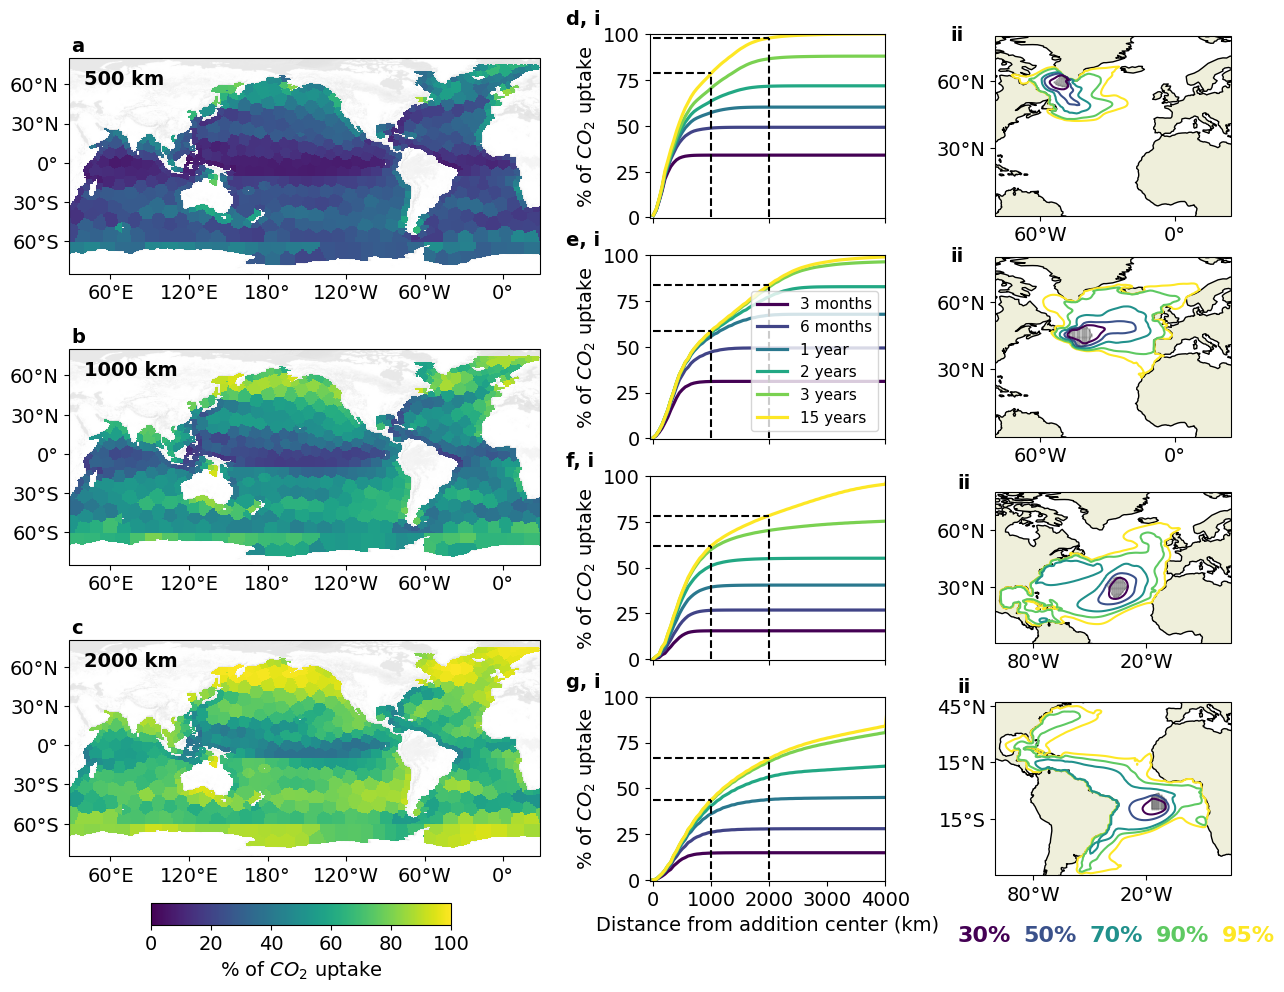

In [39]:
%%time
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(15,11))
gs = gridspec.GridSpec(4, 3, width_ratios=[2, 1, 1])

# Separate the first column into 3 rows
gs_sub1 = gs[:, 0].subgridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.1)

# Now you can access the subgridspec for the first column like this:
ax1 = plt.subplot(gs_sub1[0, 0])
ax2 = plt.subplot(gs_sub1[1, 0])
ax3 = plt.subplot(gs_sub1[2, 0])


################## global maps
time_window = 180
dist2center = 1000

FONTSIZE = 14
def modify(ax):
    ax.set_extent([0, 360, -85, 80], crs=ccrs.PlateCarree())
    #ax.stock_img()
    ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

central_longitude=208

dist2center = [500, 1000, 2000]
labels = ['a  500 km', 'b  1000 km', 'c  2000 km']

for i in range(3):
    ax = plt.subplot(gs_sub1[i, 0],  projection=ccrs.PlateCarree(central_longitude=central_longitude))
    #ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.pcolormesh(mean_over_season.TLONG, mean_over_season.TLAT, mean_over_season.sel(time_window=time_window, dist2center=dist2center[i]).uptake_percent, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=100)
    
    ax.text(40, 60, labels[i][3:], fontsize=FONTSIZE, transform=ccrs.PlateCarree(), fontweight='bold')
    ax.text(30, 85, labels[i][:1], fontsize=FONTSIZE, transform=ccrs.PlateCarree(), fontweight='bold')
    ax.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
    ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)
    ax.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
    ax.set_xticklabels(ax.get_xticks(), fontsize=FONTSIZE)
        
    modify(ax)
    
def add_colorbar(x0, y0, vmin, vmax, label, num_levels_ticks, cmap_label='viridis'):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar'
    '''
    cax = fig.add_axes([x0, y0, 0.2, 0.02])  # [x0, y0, width, height]
    cmap = plt.colormaps[cmap_label]
    normalize = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color values
    sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = fig.colorbar(sm, cax=cax, shrink=0.5, label=label, orientation='horizontal', ticks=np.linspace(vmin, vmax, num_levels_ticks))
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.ax.xaxis.label.set_size(FONTSIZE)

add_colorbar(0.18, 0.07, 0, 100, '% of $CO_2$ uptake', 6)


##################################### last 2 columns
colors = ['blue', 'green', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -100, -100]
lon_maxs = [25, 25, 25, 25]
lat_mins = [0, 0, 0, -45]
lat_maxs = [80, 80, 80, 47]
central_longitudes = [0, 0, 0, 0]
bin_edges_0 = np.arange(0, 4100*1e3, 50*1e3)

def modify_ax_alk(ax):
    ax.set_ylim(5000, 1)
    ax.set_yscale('log')
    
    custom_y_ticks = [10, 100, 500, 1000, 4000]
    custom_y_labels  = [str(num) for num in custom_y_ticks]
    ax.set_yticks(custom_y_ticks)
    ax.set_yticklabels(custom_y_labels);
    
    ax.set_xlim(-0.01, 0.6)
    custom_x_ticks = np.arange(0, 0.7, 0.1)
    custom_x_labels  = [0, 0.1, 0, 0.1, 0, 0.1, 0.2]
    custom_x_labels = [str(num) for num in custom_x_labels]
    ax.set_xticks(custom_x_ticks)
    ax.set_xticklabels(custom_x_labels);


for i in range(4):
    oae_ = oae_effs[i] # OAE_result for a region
    frac_alk_ = fra_alks[i] # frac_alk for a region
    surf_dil = all_curves_global.sel(region=reg, polygon=polys[i])  # surface dilution curves for a polygon, with 4 seasons
    tau_comp = all_curves_global_tau_FG_CO2.sel(region=reg, polygon=polys[i]) # tau gax componets for a region

    
    for j in range(3):
       
        if j == 2:
            
            ax = plt.subplot(gs[i, j], projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            
            ### add map
            ds_ = util.pop_add_cyclic(ds_frac_FG_CO2_map[i])

            lon_min = lon_mins[i]
            lon_max = lon_maxs[i]
            lat_min = lat_mins[i]
            lat_max = lat_maxs[i]
            
            custom_colorbar_ticks = L_max_value[i]

            sca = ax.contour(ds_.TLONG, ds_.TLAT, ds_.frac_FG_CO2_cumul,
                              transform=ccrs.PlateCarree(),
                              cmap=plt.cm.RdYlGn,
                              levels = custom_colorbar_ticks,
                              extend='both',
                              linewidth=2.3
                              #norm=LogNorm(),           
                             );

            # Specify different colors for each level
            # contour_colors = ['blue', 'cyan', 'orange', 'red', 'purple']
            
            # Sample colors from the colormap
            cmap = plt.get_cmap('viridis')
            contour_colors = [cmap(i) for i in np.linspace(0, 1, 5)][::-1]
            
            #contour_colors.reverse()
            for o, collection in enumerate(sca.collections):
                collection.set_edgecolor(contour_colors[o])
            
            #### add numbers in contour lines
            # arr = get_sum_inside(ds_, ranges)
            # int_array = list(map(int, arr))

            
            fmt = {}
            strs = [str(ele)+'%' for ele in L_target_sums[i]]
            print(strs)
            for l, s in zip(sca.levels, strs):
                fmt[l] = s
            
            # Label every other level using strings
            ax.clabel(sca, sca.levels, inline=True, fmt=fmt, fontsize=20, inline_spacing=3, colors='k')

                    
            def modify(ax):
                ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
                ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
                lon_formatter = LongitudeFormatter(zero_direction_label=False)
                lat_formatter = LatitudeFormatter()
                ax.xaxis.set_major_formatter(lon_formatter)
                ax.yaxis.set_major_formatter(lat_formatter) 
                #ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

                ax.add_feature(cfeature.LAND, edgecolor='black')
            modify(ax)
            ## add polygons
            if i == 0:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 0)
                ax.text(-100, 78, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 1:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 126)
                ax.text(-100, 78, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 2:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 142)
                ax.text(-120, 82, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 3:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 129)
                ax.text(-120, 52, 'ii', fontsize=FONTSIZE, fontweight='bold')
                percents = [30, 50, 70, 90, 95]
                for kk in range(5):
                    ax.text(-120 + kk*35, -80, f'{percents[kk]}%', fontsize=16, fontweight='bold', color=contour_colors[4-kk])

                
        ################## seasonla mean, CO2 uptake histogram
        elif j == 1:
       
            ax = plt.subplot(gs[i, j])
            
            temp = ds_4poly.isel(polygon=i).mean(dim='season').FG_CO2_percent.values
            if i == 0:
                stacks, _ = get_cumulative_dist(temp, long=True)
            else:
                stacks, _ = get_cumulative_dist(temp)

            legends = ['3 months', '6 months', '1 year', '2 years','3 years', '15 years']
            # Sample colors from the colormap
            cmap = plt.get_cmap('viridis')
            contour_colors = [cmap(i) for i in np.linspace(0, 1, 6)]

            for jj in range(len(stacks)):
                ax.plot(bin_edges_0/1000, stacks[jj], label=legends[jj], linewidth=2.3, color=contour_colors[jj])

            ### add dashed line
            ind_1000 = np.where(bin_edges_0/1000 == 1000)
            ax.plot([1000, 1000], [0, stacks[-1][ind_1000]], 'k--')
            ax.plot([0, 1000], [stacks[-1][ind_1000], stacks[-1][ind_1000]], 'k--')

            ind_2000 = np.where(bin_edges_0/1000 == 2000)
            ax.plot([2000, 2000], [0, stacks[-1][ind_2000]], 'k--')
            ax.plot([0, 2000], [stacks[-1][ind_2000], stacks[-1][ind_2000]], 'k--')

            print('Percentage in 1000, 2000 km', stacks[-1][ind_1000], stacks[-1][ind_2000])

            if i == 1:
                ax.legend(fontsize=11, loc='lower right')
            
            ax.set_xlim(-60,4000)
            
            ax.set_xticklabels('')
            ax.set_ylim(-0.2, 100)
            if i == 3:
                ax.set_xlabel('Distance from addition center (km)')
                ax.set_xticks(np.arange(0,5000,1000))
                ax.set_xticklabels(np.arange(0,5000,1000))
            
            ax.set_yticks(np.arange(0,125,25))
            ax.set_yticklabels(np.arange(0,125,25))
        
            if i == 0:
                ax.text(-1500, 105, 'd, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 1:
                ax.text(-1500, 105, 'e, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 2:
                ax.text(-1500, 105, 'f, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 3:
                ax.text(-1500, 105, 'g, i', fontsize=FONTSIZE, fontweight='bold')
            
            ax.set_ylabel('% of $CO_2$ uptake')

            
                
plt.subplots_adjust(wspace=0.35, hspace=0.2)

# plt.savefig('./figures/Figure_6.png', dpi=400, bbox_inches='tight')
# plt.savefig('./figures/Figure_6.pdf', bbox_inches='tight')

## numbers in paper

In [122]:
temp = ds_4poly.isel(polygon=1).mean(dim='season').FG_CO2_percent.values
stacks, _ = get_cumulative_dist(temp)
# ['3 months', '6 months', '1 year', '2 years','3 years', '15 years']

In [123]:
# year 2
stacks[3]

array([ 0.49283193,  1.98221034,  4.39193152,  7.44233332, 11.48251657,
       15.57232306, 20.85523812, 25.31173987, 30.34313222, 34.77021407,
       37.88453364, 41.2467859 , 43.2990833 , 46.24115605, 48.41167329,
       50.20617128, 52.03797055, 53.26771355, 54.95959515, 56.18400085,
       57.5834011 , 58.89731429, 59.73268401, 61.1400197 , 62.1023017 ,
       63.19438211, 64.35405454, 65.10599321, 66.34656585, 67.33564148,
       68.27440283, 69.33738484, 70.0058381 , 71.16673389, 72.14938624,
       72.86782813, 73.94165222, 74.7880162 , 75.53279682, 76.50398394,
       77.14610602, 77.92184682, 78.68143727, 79.09276744, 79.75139672,
       80.26662938, 80.61799171, 81.01273008, 81.35491754, 81.59888893,
       81.80907964, 81.99509449, 82.12441903, 82.22104821, 82.31298282,
       82.37812537, 82.43010573, 82.46170366, 82.48211511, 82.50249001,
       82.51645859, 82.52948188, 82.53948713, 82.54678388, 82.55223426,
       82.55650284, 82.55971059, 82.56270673, 82.56495017, 82.56

In [145]:
# index of 1000km
np.argmax(bin_edges_0/1000 == 1000), np.argmax(bin_edges_0/1000 == 2000)

(20, 40)

In [146]:
# year 15
stacks[-1][20], stacks[-1][40]

(58.683408997204964, 83.60990448393156)

Data used in Figure 6

In [130]:
whole_ds = xr.open_dataset('./Uptake_percent_maps_all.nc')


In [140]:
whole_ds['dist2center'].attrs['units'] = 'km'
whole_ds['time_window'].attrs['units'] = 'months'
whole_ds['time_window'].attrs['details'] = 'cumulative uptake up until this time step'

In [142]:
whole_ds

<xarray.Dataset>
Dimensions:         (time_window: 7, dist2center: 82, season: 4, nlat: 384, nlon: 320)
Coordinates:
  * time_window     (time_window) int64 3 6 12 24 60 120 180
  * dist2center     (dist2center) float64 0.0 50.0 100.0 ... 4e+03 4.05e+03
  * season          (season) object 'Januaray' 'April' 'July' 'October'
    TLONG           (nlat, nlon) float64 ...
    TLAT            (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    uptake_percent  (time_window, dist2center, season, nlat, nlon) float64 ...

In [143]:
whole_ds.isel(nlat=0, nlon=0)

<xarray.Dataset>
Dimensions:         (time_window: 7, dist2center: 82, season: 4)
Coordinates:
  * time_window     (time_window) int64 3 6 12 24 60 120 180
  * dist2center     (dist2center) float64 0.0 50.0 100.0 ... 4e+03 4.05e+03
  * season          (season) object 'Januaray' 'April' 'July' 'October'
    TLONG           float64 ...
    TLAT            float64 ...
Data variables:
    uptake_percent  (time_window, dist2center, season) float64 ...

## Exporting spread data

In [152]:
d1 = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/FG_CO2_histogram_all.nc')

In [153]:
d1

<xarray.Dataset>
Dimensions:         (polygon: 300, region: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * region          (region) object 'North_Atlantic_basin' ... 'Southern_Ocean'
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (region, polygon, season, time, dist2center) float64 ...

In [165]:
def get_cumulative_dist(FG_CO2_rings_per, long=False):

    '''
    FG_CO2_rings_per: shape of (time, dist2center)=(180,82),
    '''
    
    r=0
    stacks = np.empty(180, 82) # (time, dist2center)

    for rs in all_rs:
        # sum individual histograms across the time axis into groups.
        sum_over_time = np.sum(FG_CO2_rings_per[r:rs],axis=0)*100
        cum_sum = np.cumsum(sum_over_time)
        stacks.append(cum_sum)
        
    return stacks

In [166]:
temp = ds_4poly.isel(polygon=1).mean(dim='season').FG_CO2_percent.values

In [208]:
def cumsum_2d(temp):
    
    '''
    temp: shape of (time, dist2center)=(180,82),

    same as this function I wrote: def get_cumulative_dist(FG_CO2_rings_per, long=False):  O_o
    '''
    
    ## 2D cumumlative sum
    # Step 1: Cumulative sum along the rows (axis=0)
    cumsum_rows = np.cumsum(temp, axis=0)
    # Step 2: Cumulative sum along the columns (axis=1)
    cumsum_2d = np.cumsum(cumsum_rows, axis=1)*100

    return cumsum_2d

cumsum_2d = cumsum_2d(temp)

Try to perform this over the whole array

In [209]:
## 2D cumumlative sum
cumsum_rows_whole = np.cumsum(d1.FG_CO2_percent, axis=3)
cumsum_2d_whole = np.cumsum(cumsum_rows_whole, axis=4)*100

In [211]:
cumsum_2d_whole_mean_over_season = cumsum_2d_whole.mean(dim='season')

In [228]:
dataset = cumsum_2d_whole_mean_over_season.to_dataset()
dataset = dataset.rename({"FG_CO2_percent": "FG_CO2_percent_cumulative"})

dataset.time.attrs['unit'] = 'month'
dataset.dist2center.attrs['unit'] = 'm'
dataset.FG_CO2_percent_cumulative.attrs['detail'] = 'Cumulative percent of CO2 uptake, within a time step and distance to center'

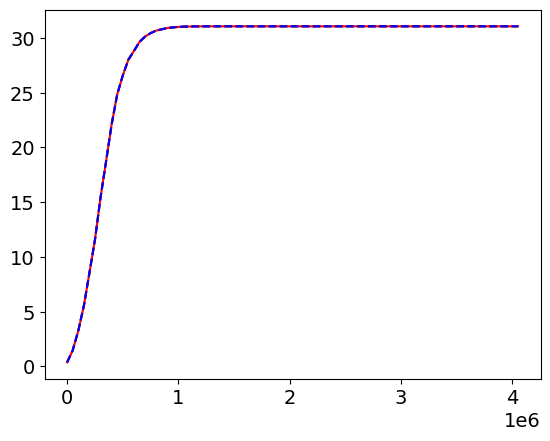

In [227]:
plt.plot(d1.dist2center, cumsum_2d[2, :], 'k--')
plt.plot(d1.dist2center, stacks[0], 'r')

plt.plot(d1.dist2center, dataset.FG_CO2_percent_cumulative[0,126,2, :], 'b--')

keep the seasonal information

In [230]:
dataset_4season = cumsum_2d_whole.to_dataset()
dataset_4season = dataset_4season.rename({"FG_CO2_percent": "FG_CO2_percent_cumulative"})

dataset_4season.time.attrs['unit'] = 'month'
dataset_4season.dist2center.attrs['unit'] = 'm'
dataset_4season.FG_CO2_percent_cumulative.attrs['detail'] = 'Cumulative percent of CO2 uptake, within a time step and distance to center'

In [231]:
dataset_4season

<xarray.Dataset>
Dimensions:                    (polygon: 300, region: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon                    (polygon) int64 0 1 2 3 4 ... 295 296 297 298 299
  * region                     (region) object 'North_Atlantic_basin' ... 'So...
  * season                     (season) object 'Januaray' 'April' ... 'October'
  * time                       (time) int64 0 1 2 3 4 5 ... 175 176 177 178 179
  * dist2center                (dist2center) float64 0.0 5e+04 ... 4.05e+06
Data variables:
    FG_CO2_percent_cumulative  (region, polygon, season, time, dist2center) float64 ...

In [238]:
dataset_4season.to_netcdf('./Cumulative_FG_CO2_percent.nc', mode='w')